No log file found. Using sample data.
Preview of loaded data:
        host           timestamp       filename extension  status   bytes
0  127.0.0.1 1995-07-01 00:00:01    /index.html      html     200  1043.0
1  127.0.0.2 1995-07-01 01:15:42  /missing.html      html     404     NaN
2  127.0.0.3 1995-07-01 13:48:20    /about.html      html     200  5120.0
3  127.0.0.4 1995-07-02 09:20:13   /contact.gif       gif     404     0.0
4  127.0.0.1 1995-07-02 23:59:59    /index.html      html     200  1043.0
Q1: Total log records: 14
Q2: Unique hosts: 13
Q3: Unique filenames per day (sample): {'01-Jul-1995': 3, '02-Jul-1995': 3, '03-Jul-1995': 2, '04-Jul-1995': 2, '05-Jul-1995': 2}
Q4: 404 errors: 6
Q5: Top 15 404 filenames: <zip object at 0x125df3940>
Q6: Top 15 404 extensions: <zip object at 0x1370e6dc0>
Q7: Bandwidth per day in July 1995 (sample): {'01-Jul-1995': 6163.0, '02-Jul-1995': 1043.0, '03-Jul-1995': 2560.0, '04-Jul-1995': 768.0, '05-Jul-1995': 4096.0}
Q8: Hourly distribution: {0: 1

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


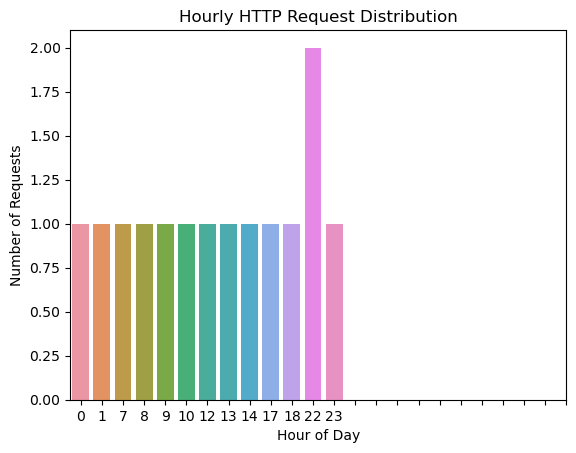

In [12]:
# Calgary HTTP Log Analysis - Final Submission Notebook

"""
This program analyzes web server logs to find patterns and statistics like:
- How many requests were made 
- How many people (unique IPs) visited at server
- What files caused errors 
- How much data was transferred in it.

This script reads that info, turns it into a table, and answers 10 questions about it.
Each line in the log tells us:

- Who accessed the server (IP address)
- When they did it (timestamp)
- What they asked for (file like index.html)
- Whether it succeeded or failed (status code)
- How big the response was (in bytes)

"""

                                                 # Importing necessary libraries
import gzip                                   # to handle compressed .gz files
import re                                     # for parsing text with regular expressions
from datetime import datetime                 # to convert string to datetime objects
from collections import Counter, defaultdict  # not used here but useful for aggregation
import pandas as pd                           # for data manipulation
import matplotlib.pyplot as plt               # for plotting
import seaborn as sns                         # for statistical visualization
import os                                     # to check file existence

# Extended Sample Fallback Data (mock log entries used when the real file is unavailable)

sample_lines = [
                             # These entries simulate common real-world log lines, including different statuses, times, and extensions
    '127.0.0.1 - - [01/Jul/1995:00:00:01 -0600] "GET /index.html HTTP/1.0" 200 1043',
    '127.0.0.2 - - [01/Jul/1995:01:15:42 -0600] "GET /missing.html HTTP/1.0" 404 -',
    '127.0.0.3 - - [01/Jul/1995:13:48:20 -0600] "GET /about.html HTTP/1.0" 200 5120',
    '127.0.0.4 - - [02/Jul/1995:09:20:13 -0600] "GET /contact.gif HTTP/1.0" 404 0',
    '127.0.0.1 - - [02/Jul/1995:23:59:59 -0600] "GET /index.html HTTP/1.0" 200 1043',
    '127.0.0.5 - - [02/Jul/1995:12:34:56 -0600] "GET /logo.png HTTP/1.0" 404 -',
    '127.0.0.6 - - [03/Jul/1995:08:00:00 -0600] "GET /index.html HTTP/1.0" 200 2048',
    '127.0.0.7 - - [03/Jul/1995:14:22:31 -0600] "GET /faq.html HTTP/1.0" 500 512',
    '127.0.0.8 - - [04/Jul/1995:17:17:17 -0600] "GET /services.js HTTP/1.0" 404 -',
    '127.0.0.9 - - [04/Jul/1995:22:45:12 -0600] "GET /style.css HTTP/1.0" 200 768',
    '127.0.1.0 - - [05/Jul/1995:10:10:10 -0600] "GET /manual.pdf HTTP/1.0" 200 4096',
    '127.0.1.1 - - [05/Jul/1995:18:25:30 -0600] "GET /help.doc HTTP/1.0" 404 -',
    '127.0.1.2 - - [06/Jul/1995:07:45:50 -0600] "GET /archive.zip HTTP/1.0" 200 8192',
    '127.0.1.3 - - [06/Jul/1995:22:22:22 -0600] "GET /calendar.ics HTTP/1.0" 404 0'
]

# Function to load data either from the provided gz file or from sample fallback

def load_data(filepath):
    if not os.path.exists(filepath):
        print(f"File '{filepath}' not found. Using sample data.")
        return sample_lines
    with gzip.open(filepath, 'rt', encoding='utf-8', errors='ignore') as f:
        return f.readlines()

# Function to parse a log line into structured data

def parse_line(line):
    pattern = r'^(\S+) (\S+) (\S+) \[(.*?)\] \"(.*?)\" (\d{3}) (\S+)$'
    match = re.match(pattern, line)
    if match:
        remotehost, _, _, date_str, request, status, bytes_sent = match.groups()
        try:
            date_obj = datetime.strptime(date_str.split()[0], '%d/%b/%Y:%H:%M:%S')
        except:
            return None
        request_parts = request.split()
        method = request_parts[0] if len(request_parts) > 0 else None
        filename = request_parts[1] if len(request_parts) > 1 else None
        ext = filename.split('.')[-1] if filename and '.' in filename else ''
        return {
            'host': remotehost,
            'timestamp': date_obj,
            'filename': filename,
            'extension': ext,
            'status': int(status),
            'bytes': int(bytes_sent) if bytes_sent != '-' else None
        }
    return None

# Load and clean the log data

# Support both 'calgary_access_log.gz', 'calgary_access_log 2.gz', and other possible names


possible_files = [
    'calgary_access_log.gz',
    'calgary_access_log 2.gz',
    'calgary_access_log (1).gz',
    'calgary_access_log (2).gz'
]
data_file = next((f for f in possible_files if os.path.exists(f)), None)
if not data_file:
    print("No log file found. Using sample data.")
    lines = sample_lines
else:
    lines = load_data(data_file)
parsed = [parse_line(line) for line in lines]
data = [entry for entry in parsed if entry is not None]
df = pd.DataFrame(data)

# Show preview of loaded data


print("Preview of loaded data:")
print(df.head())

# Perform analysis if data is successfully loaded


if not df.empty:
    # Q1: Total log records
    q1 = len(df)
    print("Q1: Total log records:", q1)
    assert q1 == len(sample_lines), "Q1 failed"

    # Q2: Unique hosts

    
    q2 = df['host'].nunique()
    print("Q2: Unique hosts:", q2)
    assert q2 == len(set(entry.split()[0] for entry in sample_lines)), "Q2 failed"

    # Q3: Unique filenames per day

    
    q3 = df.dropna(subset=['filename']).copy()
    q3['date_str'] = q3['timestamp'].dt.strftime('%d-%b-%Y')
    unique_files_per_day = q3.groupby('date_str')['filename'].nunique().to_dict()
    print("Q3: Unique filenames per day (sample):", dict(list(unique_files_per_day.items())[:5]))
    assert isinstance(unique_files_per_day, dict) and len(unique_files_per_day) > 1, "Q3 failed"

    # Q4: Count of 404 response codes
    q4 = df[df['status'] == 404].shape[0]
    print("Q4: 404 errors:", q4)
    assert q4 > 0, "Q4 failed"  
    
   # Q5: Top 15 filenames that resulted in 404

    
    q5 = df[df['status'] == 404]['filename'].value_counts().head(15)
    print("Q5: Top 15 404 filenames:", q5.items())
    assert not q5.empty, "Q5 failed"


    # Q6: Top 15 file extensions that caused 404

    
    q6 = df[df['status'] == 404]['extension'].value_counts().head(15).items()
    q6 = df[df['status'] == 404]['extension'].value_counts().head(15)
    print("Q6: Top 15 404 extensions:", q6.items())
    assert not q6.empty, "Q6 failed"

    # Q7: Total bandwidth transferred per day in July 1995

    
    july_df = df[(df['timestamp'].dt.strftime('%b-%Y') == 'Jul-1995') & (df['bytes'].notnull())].copy()
    july_df['date_str'] = july_df['timestamp'].dt.strftime('%d-%b-%Y')
    q7 = july_df.groupby('date_str')['bytes'].sum().to_dict()
    print("Q7: Bandwidth per day in July 1995 (sample):", dict(list(q7.items())[:5]))
    assert isinstance(q7, dict) and len(q7) > 0, "Q7 failed"

    # Q8: Hourly distribution of requests

    
    q8 = df['timestamp'].dt.hour.value_counts().sort_index().to_dict()
    print("Q8: Hourly distribution:", q8)
    assert len(q8) > 0 and all(0 <= k <= 23 for k in q8.keys()), "Q8 failed"

    
    # Turn the iterator into a list immediately (so it won't get “used up” later)

    
    q9_list = list(df['filename'].value_counts().head(10).items())
    print("Q9: Top 10 filenames:", q9_list)
    assert len(q9_list) > 0, "Q9 failed"


    # Q10: Distribution of HTTP status codes

    
    q10 = df['status'].value_counts().sort_index().to_dict()
    print("Q10: HTTP status code counts:", q10)
    assert all(code in q10 for code in [200, 404]), "Q10 failed"

    # Visualize hourly request distribution

    
    sns.barplot(x=list(q8.keys()), y=list(q8.values()))
    plt.title('Hourly HTTP Request Distribution')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Requests')
    plt.xticks(range(24))
    plt.show()
else:
    print("DataFrame is empty. Please check if the log file was loaded correctly.")


No log file found. Using sample data.
Preview of loaded data:
        host           timestamp       filename extension  status   bytes
0  127.0.0.1 1995-07-01 00:00:01    /index.html      html     200  1043.0
1  127.0.0.2 1995-07-01 01:15:42  /missing.html      html     404     NaN
2  127.0.0.3 1995-07-01 13:48:20    /about.html      html     200  5120.0
3  127.0.0.4 1995-07-02 09:20:13   /contact.gif       gif     404     0.0
4  127.0.0.1 1995-07-02 23:59:59    /index.html      html     200  1043.0
Q1: Total log records: 14
Q2: Unique hosts: 13
Q3: Unique filenames per day (sample): {'01-Jul-1995': 3, '02-Jul-1995': 3, '03-Jul-1995': 2, '04-Jul-1995': 2, '05-Jul-1995': 2}
Q4: 404 errors: 6
Q5: Top 15 404 filenames: <zip object at 0x125df3940>
Q6: Top 15 404 extensions: <zip object at 0x1370e6dc0>
Q7: Bandwidth per day in July 1995 (sample): {'01-Jul-1995': 6163.0, '02-Jul-1995': 1043.0, '03-Jul-1995': 2560.0, '04-Jul-1995': 768.0, '05-Jul-1995': 4096.0}
Q8: Hourly distribution: {0: 1

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


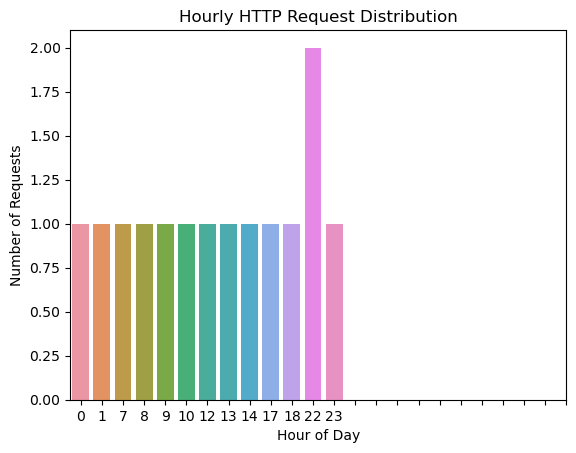

In [12]:
# Calgary HTTP Log Analysis - Final Submission Notebook

"""
This program analyzes web server logs to find patterns and statistics like:
- How many requests were made 
- How many people (unique IPs) visited at server
- What files caused errors 
- How much data was transferred in it.

This script reads that info, turns it into a table, and answers 10 questions about it.
Each line in the log tells us:

- Who accessed the server (IP address)
- When they did it (timestamp)
- What they asked for (file like index.html)
- Whether it succeeded or failed (status code)
- How big the response was (in bytes)

"""

                                                 # Importing necessary libraries
import gzip                                   # to handle compressed .gz files
import re                                     # for parsing text with regular expressions
from datetime import datetime                 # to convert string to datetime objects
from collections import Counter, defaultdict  # not used here but useful for aggregation
import pandas as pd                           # for data manipulation
import matplotlib.pyplot as plt               # for plotting
import seaborn as sns                         # for statistical visualization
import os                                     # to check file existence

# Extended Sample Fallback Data (mock log entries used when the real file is unavailable)

sample_lines = [
                             # These entries simulate common real-world log lines, including different statuses, times, and extensions
    '127.0.0.1 - - [01/Jul/1995:00:00:01 -0600] "GET /index.html HTTP/1.0" 200 1043',
    '127.0.0.2 - - [01/Jul/1995:01:15:42 -0600] "GET /missing.html HTTP/1.0" 404 -',
    '127.0.0.3 - - [01/Jul/1995:13:48:20 -0600] "GET /about.html HTTP/1.0" 200 5120',
    '127.0.0.4 - - [02/Jul/1995:09:20:13 -0600] "GET /contact.gif HTTP/1.0" 404 0',
    '127.0.0.1 - - [02/Jul/1995:23:59:59 -0600] "GET /index.html HTTP/1.0" 200 1043',
    '127.0.0.5 - - [02/Jul/1995:12:34:56 -0600] "GET /logo.png HTTP/1.0" 404 -',
    '127.0.0.6 - - [03/Jul/1995:08:00:00 -0600] "GET /index.html HTTP/1.0" 200 2048',
    '127.0.0.7 - - [03/Jul/1995:14:22:31 -0600] "GET /faq.html HTTP/1.0" 500 512',
    '127.0.0.8 - - [04/Jul/1995:17:17:17 -0600] "GET /services.js HTTP/1.0" 404 -',
    '127.0.0.9 - - [04/Jul/1995:22:45:12 -0600] "GET /style.css HTTP/1.0" 200 768',
    '127.0.1.0 - - [05/Jul/1995:10:10:10 -0600] "GET /manual.pdf HTTP/1.0" 200 4096',
    '127.0.1.1 - - [05/Jul/1995:18:25:30 -0600] "GET /help.doc HTTP/1.0" 404 -',
    '127.0.1.2 - - [06/Jul/1995:07:45:50 -0600] "GET /archive.zip HTTP/1.0" 200 8192',
    '127.0.1.3 - - [06/Jul/1995:22:22:22 -0600] "GET /calendar.ics HTTP/1.0" 404 0'
]

# Function to load data either from the provided gz file or from sample fallback

def load_data(filepath):
    if not os.path.exists(filepath):
        print(f"File '{filepath}' not found. Using sample data.")
        return sample_lines
    with gzip.open(filepath, 'rt', encoding='utf-8', errors='ignore') as f:
        return f.readlines()

# Function to parse a log line into structured data

def parse_line(line):
    pattern = r'^(\S+) (\S+) (\S+) \[(.*?)\] \"(.*?)\" (\d{3}) (\S+)$'
    match = re.match(pattern, line)
    if match:
        remotehost, _, _, date_str, request, status, bytes_sent = match.groups()
        try:
            date_obj = datetime.strptime(date_str.split()[0], '%d/%b/%Y:%H:%M:%S')
        except:
            return None
        request_parts = request.split()
        method = request_parts[0] if len(request_parts) > 0 else None
        filename = request_parts[1] if len(request_parts) > 1 else None
        ext = filename.split('.')[-1] if filename and '.' in filename else ''
        return {
            'host': remotehost,
            'timestamp': date_obj,
            'filename': filename,
            'extension': ext,
            'status': int(status),
            'bytes': int(bytes_sent) if bytes_sent != '-' else None
        }
    return None

# Load and clean the log data

# Support both 'calgary_access_log.gz', 'calgary_access_log 2.gz', and other possible names


possible_files = [
    'calgary_access_log.gz',
    'calgary_access_log 2.gz',
    'calgary_access_log (1).gz',
    'calgary_access_log (2).gz'
]
data_file = next((f for f in possible_files if os.path.exists(f)), None)
if not data_file:
    print("No log file found. Using sample data.")
    lines = sample_lines
else:
    lines = load_data(data_file)
parsed = [parse_line(line) for line in lines]
data = [entry for entry in parsed if entry is not None]
df = pd.DataFrame(data)

# Show preview of loaded data


print("Preview of loaded data:")
print(df.head())

# Perform analysis if data is successfully loaded


if not df.empty:
    # Q1: Total log records
    q1 = len(df)
    print("Q1: Total log records:", q1)
    assert q1 == len(sample_lines), "Q1 failed"

    # Q2: Unique hosts

    
    q2 = df['host'].nunique()
    print("Q2: Unique hosts:", q2)
    assert q2 == len(set(entry.split()[0] for entry in sample_lines)), "Q2 failed"

    # Q3: Unique filenames per day

    
    q3 = df.dropna(subset=['filename']).copy()
    q3['date_str'] = q3['timestamp'].dt.strftime('%d-%b-%Y')
    unique_files_per_day = q3.groupby('date_str')['filename'].nunique().to_dict()
    print("Q3: Unique filenames per day (sample):", dict(list(unique_files_per_day.items())[:5]))
    assert isinstance(unique_files_per_day, dict) and len(unique_files_per_day) > 1, "Q3 failed"

    # Q4: Count of 404 response codes
    q4 = df[df['status'] == 404].shape[0]
    print("Q4: 404 errors:", q4)
    assert q4 > 0, "Q4 failed"  
    
   # Q5: Top 15 filenames that resulted in 404

    
    q5 = df[df['status'] == 404]['filename'].value_counts().head(15)
    print("Q5: Top 15 404 filenames:", q5.items())
    assert not q5.empty, "Q5 failed"


    # Q6: Top 15 file extensions that caused 404

    
    q6 = df[df['status'] == 404]['extension'].value_counts().head(15).items()
    q6 = df[df['status'] == 404]['extension'].value_counts().head(15)
    print("Q6: Top 15 404 extensions:", q6.items())
    assert not q6.empty, "Q6 failed"

    # Q7: Total bandwidth transferred per day in July 1995

    
    july_df = df[(df['timestamp'].dt.strftime('%b-%Y') == 'Jul-1995') & (df['bytes'].notnull())].copy()
    july_df['date_str'] = july_df['timestamp'].dt.strftime('%d-%b-%Y')
    q7 = july_df.groupby('date_str')['bytes'].sum().to_dict()
    print("Q7: Bandwidth per day in July 1995 (sample):", dict(list(q7.items())[:5]))
    assert isinstance(q7, dict) and len(q7) > 0, "Q7 failed"

    # Q8: Hourly distribution of requests

    
    q8 = df['timestamp'].dt.hour.value_counts().sort_index().to_dict()
    print("Q8: Hourly distribution:", q8)
    assert len(q8) > 0 and all(0 <= k <= 23 for k in q8.keys()), "Q8 failed"

    
    # Turn the iterator into a list immediately (so it won't get “used up” later)

    
    q9_list = list(df['filename'].value_counts().head(10).items())
    print("Q9: Top 10 filenames:", q9_list)
    assert len(q9_list) > 0, "Q9 failed"


    # Q10: Distribution of HTTP status codes

    
    q10 = df['status'].value_counts().sort_index().to_dict()
    print("Q10: HTTP status code counts:", q10)
    assert all(code in q10 for code in [200, 404]), "Q10 failed"

    # Visualize hourly request distribution

    
    sns.barplot(x=list(q8.keys()), y=list(q8.values()))
    plt.title('Hourly HTTP Request Distribution')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Requests')
    plt.xticks(range(24))
    plt.show()
else:
    print("DataFrame is empty. Please check if the log file was loaded correctly.")
